In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
pre_fname = '/Users/abrahamflamholz/BDrive/Research/Savage/CarboxeColi/phenotyping/102919 CCMB1 dcbbQ dacRAF exp/102919 preculture ODs.xlsx'
exp_fname = '/Users/abrahamflamholz/BDrive/Research/Savage/CarboxeColi/phenotyping/102919 CCMB1 dcbbQ dacRAF exp/111119 culture ODs.xlsx'

In [3]:
# Cultures of CCMB1 + pFE-lsPrk in glycerol and xylose + 12C/13C bicarb for LCMS work.
# Also did pos and negative controls in air and 10% CO2. Measured all the ODs. 
pre_df = pd.read_excel(pre_fname, dtype={'OD600': float})
exp_df = pd.read_excel(exp_fname, dtype={'OD600': float})

# Negative controls precultures were in LB. Set the LB precultures to NaN since they are not comparable.
lb_mask = [m.startswith('LB') for m in pre_df.media]
pre_df.at[lb_mask, 'OD600'] = np.NaN

In [4]:
# Make a color palette for the swarmplot that colors replicates differently.
greys = sns.color_palette('Greys', n_colors=8)
greens = sns.color_palette('Greens', n_colors=8)
purples = sns.color_palette('Purples', n_colors=8)
reddish_purple = sns.set_hls_values(sns.xkcd_rgb['reddish purple'], 0.9, 0.3, 1)

In [5]:
def make_matched_culture_subplot(dataset_df, bar_order, ticknames,
                                 colors_10pct, colors_amb, first_hatch_idx):
    amb_df = dataset_df[dataset_df.cond == 'amb']
    highCO2_df = dataset_df[dataset_df.cond == '10% CO2']
    
    mean_10pct = highCO2_df.groupby('short_name').mean()
    mean_amb = amb_df.groupby('short_name').mean()
    std_10pct = highCO2_df.groupby('short_name').std()
    std_amb = amb_df.groupby('short_name').std()
    
    bo = bar_order
    xs = np.arange(len(bo))
    width = 0.4
    offset = width/2
    bars_10pct = plt.bar(xs-offset, mean_10pct.loc[bo].OD600.values, color=colors_10pct, width=width, edgecolor='k')
    bars_amb = plt.bar(xs+offset, mean_amb.loc[bo].OD600.values, color=colors_amb, width=width, edgecolor='k')

    for bar in bars_10pct[first_hatch_idx:]:
        bar.set_hatch('//')
    for bar in bars_amb[first_hatch_idx:]:
        bar.set_hatch('//')

    for i, name in enumerate(bo):
        n = (highCO2_df.short_name == name).sum()
        my_xs = np.ones(n)*i

        plt.scatter(my_xs-offset, highCO2_df[highCO2_df.short_name == name].OD600.values,
                    marker='D', s=25, color=greys[3], edgecolors='k', zorder=10)
        plt.scatter(my_xs+offset, amb_df[amb_df.short_name == name].OD600.values,
                    marker='D', s=25, color=greys[1], edgecolors='k', zorder=10)

    # TODO: prefer 95% CI to std deviation
    plt.errorbar(xs-0.2, mean_10pct.loc[order].OD600.values,
                 yerr=std_10pct.loc[order].OD600.values, color='k', ls='', elinewidth=2)
    plt.errorbar(xs+0.2, mean_amb.loc[order].OD600.values,
                 yerr=std_amb.loc[order].OD600.values, color='k', ls='', elinewidth=2)
    

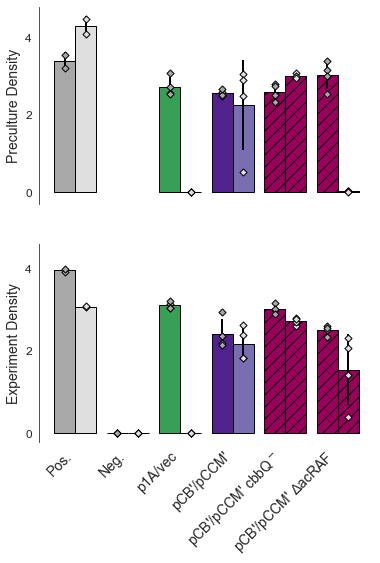

In [7]:
order = ['pos', 'K194M', 'lsPrk', '13.6 plasmids', '13.6 dCbbQ', '13.6 dAcRAF', ]
ticknames = ['Pos.', "Neg.", 'p1A/vec', "pCB'/pCCM'",
 "pCB'/pCCM' cbbQ$^-$", "pCB'/pCCM' $\Delta$acRAF"]

bars_10pct = [
    greys[3], greys[3], # controls - grey
    # Rubisco alone/no carboxysome - green
    greens[-3],
    # Full CCM gene set
    purples[-1],
    # Mutants with most of the CCM are red/purple
    reddish_purple, reddish_purple]

bars_amb = [
    greys[1], greys[1],
    greens[-4],
    purples[-3],
    reddish_purple, reddish_purple, ]

fig = plt.figure(figsize=(6,8))
sns.set_style('white')

gs = plt.GridSpec(2, 1, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0])

make_matched_culture_subplot(pre_df, order, ticknames, bars_10pct, bars_amb, first_hatch_idx=-2)
plt.yticks(np.arange(0, 4.1, 2.0), fontsize=12)
plt.xticks([])
plt.ylabel('Preculture Density', fontsize=14)
sns.despine(bottom=True)

ax1 = plt.subplot(gs[1])

make_matched_culture_subplot(exp_df, order, ticknames, bars_10pct, bars_amb, first_hatch_idx=-2)

plt.xticks(np.arange(len(ticknames)), ticknames, rotation=45, fontsize=14, ha='right')
plt.yticks(np.arange(0, 4.1, 2.0), fontsize=12)
plt.xlabel('')
plt.ylabel('Experiment Density', fontsize=14)
plt.ylim(-0.2, 4.6)
sns.despine(bottom=True)

plt.show()